In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras import layers, Model



In [6]:
working_path = "D:/Semester 5/MachineORDeep Learning/Final Project"
# file_names = ['encoded-dogcat-img-16.csv', 'encoded-dogcat-img-32.csv', 'encoded-dogcat-img-64.csv', 'encoded-dogcat-img-128.csv']
file_names = ['encoded-dogcat-img-32.csv']

lda = LinearDiscriminantAnalysis()

In [7]:
def model_def(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),  # Layer input dengan 50 neuron
        tf.keras.layers.Dense(50, activation='relu'),  
        tf.keras.layers.Dense(4, activation='softmax') 
    ])
    return model

def model_dropout1(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

def residual_block(input_tensor, filters):
    x = tf.keras.layers.Dense(filters, activation='relu')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)

    # x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(filters, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Shortcut connection
    shortcut = tf.keras.layers.Dense(filters)(input_tensor)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    # Tambahkan shortcut ke output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_tabular(input_shape):

    # Membuat model ResNet untuk data Iris
    input_shape = input_shape

    inputs = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.Reshape((input_shape, 1))(inputs)  # Menambahkan dimensi untuk keperluan Conv1D

    x = residual_block(x, 64)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Output layer dengan 3 kelas (Iris memiliki 3 kelas)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


def set_callbacks(model_name):
    callbacks = [
    # Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi setelah beberapa epoch
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # ModelCheckpoint untuk menyimpan model dengan akurasi validasi terbaik
    ModelCheckpoint(f'models-w-0pad-wo-lda/{model_name}.h5', monitor='val_accuracy', save_best_only=True)
    ]
    return callbacks

def resnet_buPima(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)  # Tambahkan layer input
    x = tf.expand_dims(inputs, axis=-1)  # Tambahkan dimensi keempat

    resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None)
    resnet_50.trainable = False

    x = resnet_50(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten(name="flatten")(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


def model_resnetBuPim(input_shape):
  model = resnet_buPima(input_shape)
  return model

In [8]:
models = []
train_accuracies = []
test_accuracies = []
train_loss_s = []
test_loss_s = []
histories = []



for i, f in enumerate(file_names):
    print(f"==> Start Model {file_names[i]} <==")
    
    # Load dataset
    df = pd.read_csv(f'{working_path}/dataset/dogcat-encode/{f}')
    df = df.iloc[:, 1:]
    # df = df.loc[:, (df != 0).any(axis=0)]


    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]

    # Linear Discriminant Analysis (LDA)
    # lda = LinearDiscriminantAnalysis(n_components=min(X.shape[1], y.iloc[:, 0].nunique()-1))
    # X_lda = lda.fit_transform(X, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_default = model_def(X_train.shape[1])
    model_resnet = resnet_tabular(X_train.shape[1])

    models.append(model_default)
    models.append(model_resnet)
    model_names = ['neural-network', 'neural-network-modificate']
    
    for k, mod in enumerate(models): 
        # Compile model
        mod.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train model
        history = mod.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=set_callbacks(model_names[k]))
        test_loss, test_accuracy = mod.evaluate(X_test, y_test)


        # models.append(model)
        histories.append(history)

        last_accuracy = history.history['accuracy'][-1]
        train_accuracies.append(last_accuracy)
        test_accuracies.append(test_accuracy)
        train_loss_s.append(history.history['loss'][-1])
        test_loss_s.append(test_loss)

        print(f"==> End Model {file_names[i]} <==")

==> Start Model encoded-dogcat-img-32.csv <==


Epoch 1/50
21/21 [==============================] - 2s 23ms/step - loss: 1.5477 - accuracy: 0.2744 - val_loss: 1.3571 - val_accuracy: 0.4012
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 1.0028 - accuracy: 0.6589 - val_loss: 1.3348 - val_accuracy: 0.3827
Epoch 3/50
21/21 [==============================] - 0s 10ms/step - loss: 0.7305 - accuracy: 0.8434 - val_loss: 1.3432 - val_accuracy: 0.4568
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5177 - accuracy: 0.9535 - val_loss: 1.3751 - val_accuracy: 0.4321
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.3463 - accuracy: 0.9845 - val_loss: 1.4396 - val_accuracy: 0.4259
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.2220 - accuracy: 0.9953 - val_loss: 1.5088 - val_accuracy: 0.4321
Epoch 7/50
6/6 [==============================] - 0s 3ms/step - loss: 1.3348 - accuracy: 0.3827
==> End Model encoded-dogcat-img-32.csv <==
Epoch 1/50
21/21 [

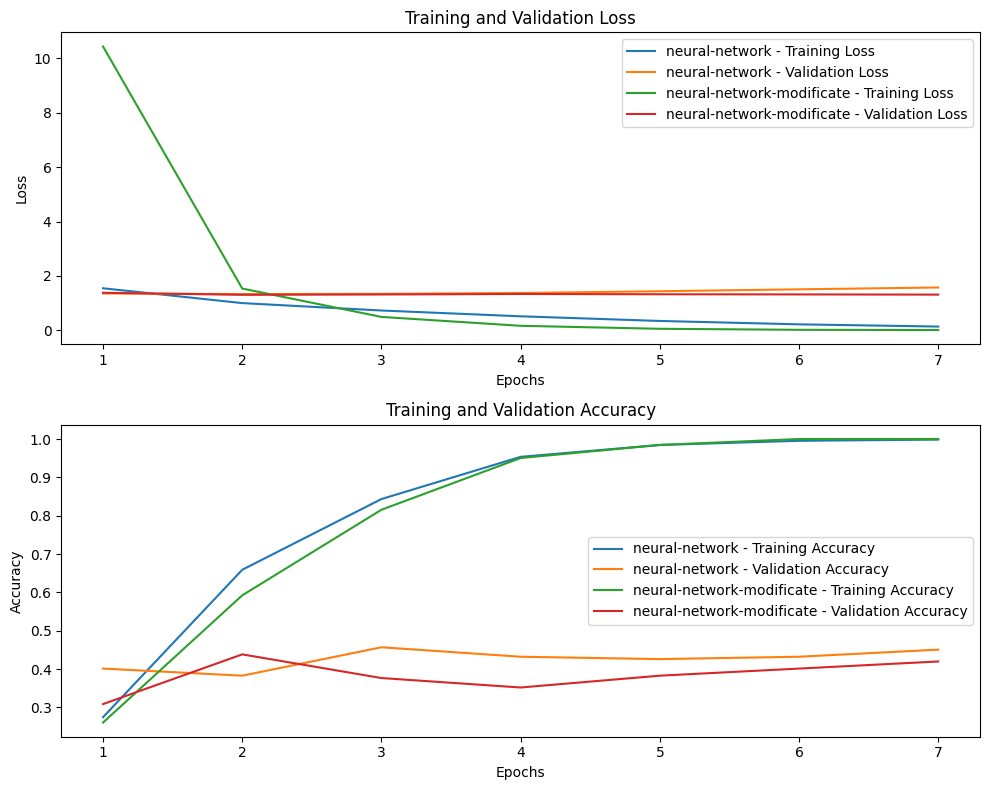

In [9]:
import numpy as np

# Mencari panjang maksimum dari histori
max_epochs = max([len(history.history['loss']) for history in histories])

# Plot loss
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama

for i, history in enumerate(histories):
    epochs = range(1, max_epochs + 1)  # Gunakan max_epochs di sini
    
    # Menyesuaikan panjang histori
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    padded_loss = np.pad(loss, (0, max_epochs - len(loss)), 'constant', constant_values=np.nan)
    padded_val_loss = np.pad(val_loss, (0, max_epochs - len(val_loss)), 'constant', constant_values=np.nan)
    
    plt.plot(epochs, padded_loss, label=f'{model_names[i]} - Training Loss')
    plt.plot(epochs, padded_val_loss, label=f'{model_names[i]} - Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot akurasi
plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua

for i, history in enumerate(histories):
    epochs = range(1, max_epochs + 1)  # Gunakan max_epochs di sini
    
    # Menyesuaikan panjang histori
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    padded_accuracy = np.pad(accuracy, (0, max_epochs - len(accuracy)), 'constant', constant_values=np.nan)
    padded_val_accuracy = np.pad(val_accuracy, (0, max_epochs - len(val_accuracy)), 'constant', constant_values=np.nan)
    
    plt.plot(epochs, padded_accuracy, label=f'{model_names[i]} - Training Accuracy')
    plt.plot(epochs, padded_val_accuracy, label=f'{model_names[i]} - Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
histories[0].history['accuracy']

[0.27441859245300293,
 0.6589147448539734,
 0.843410849571228,
 0.9534883499145508,
 0.9844961166381836,
 0.9953488111495972,
 0.9984496235847473]

In [11]:
res_nn_model = pd.DataFrame({
    'model': model_names,
    'train_loss': train_loss_s,
    'train_accuracy' : train_accuracies,
    'test_loss': test_loss_s,
    'test_accuracy' : test_accuracies,
})

res_nn_model.head()

,model,train_loss,train_accuracy,test_loss,test_accuracy
0,neural-network,0.140755,0.99845,1.334785,0.382716
1,neural-network-modificate,0.012417,1.00000,1.306908,0.438272


In [12]:
train_accuracies

[0.9984496235847473, 1.0]